# XAI Global Analysis - Feature Importance & Model Interpretation
## Analyzing the best performing model with global explainability techniques

In [28]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.inspection import permutation_importance, partial_dependence
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import accuracy_score, f1_score
import warnings
import time
import lime
import lime.lime_tabular
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

print("XAI Global Analysis - Starting...")
print("="*60)

XAI Global Analysis - Starting...


In [7]:
# Load the trained models and data
print("\n1. LOADING TRAINED MODELS AND DATA")
print("-" * 50)

# Load results to get best model
results_df = pd.read_csv('../results/model_comparison_results.csv')
best_model_name = results_df.iloc[0]['Model']
print(f"Best performing model: {best_model_name}")
print(f"Test F1-Score: {results_df.iloc[0]['Test_F1-Score']:.4f}")

# Load the best model
model_filename = f"../results/{best_model_name.replace(' ', '_').lower()}_model.joblib"
best_model = joblib.load(model_filename)
print(f"Model loaded from: {model_filename}")

# Load preprocessors
scaler = joblib.load('../results/scaler.joblib')
selector = joblib.load('../results/feature_selector.joblib')

# Try to load target encoder, create if doesn't exist
try:
    target_encoder = joblib.load('../results/target_encoder.joblib')
    print("Target encoder loaded successfully")
except FileNotFoundError:
    print("Target encoder not found, will create new one during preprocessing")
    target_encoder = None

print("Preprocessors loaded successfully")


1. LOADING TRAINED MODELS AND DATA
--------------------------------------------------
Best performing model: CatBoost
Test F1-Score: 1.0000


Model loaded from: ../results/catboost_model.joblib
Target encoder not found, will create new one during preprocessing
Preprocessors loaded successfully


In [8]:
# Load and prepare data
print("\n2. LOADING AND PREPARING DATA")
print("-" * 50)

# Load original dataset
df = pd.read_csv('../data/train_test_network.csv')
print(f"Original dataset shape: {df.shape}")

# Reproduce the same preprocessing steps
data = df.copy()
exclude_columns = ['src_ip', 'dst_ip']

# Determine target column
if 'label' in data.columns:
    target_col = 'label'
elif 'attack_type' in data.columns:
    target_col = 'attack_type'
else:
    target_col = data.columns[-1]

feature_columns = [col for col in data.columns if col not in exclude_columns]

# Remove type column if it exists (data leakage prevention)
if 'type' in feature_columns and target_col in data.columns:
    type_unique = set(data['type'].unique())
    target_unique = set(data[target_col].unique())
    if type_unique == target_unique:
        feature_columns.remove('type')
        print("Removed 'type' column to prevent data leakage")

# Separate features and target
X = data[feature_columns].drop(columns=[target_col])
y = data[target_col]

# Remove duplicates
combined_data = pd.concat([X, y], axis=1)
combined_data_clean = combined_data.drop_duplicates()
X = combined_data_clean.drop(columns=[target_col])
y = combined_data_clean[target_col]

print(f"Clean dataset shape: {X.shape}")
print(f"Target classes: {y.value_counts().to_dict()}")


2. LOADING AND PREPARING DATA
--------------------------------------------------
Original dataset shape: (211043, 44)
Clean dataset shape: (183592, 41)
Target classes: {1: 141615, 0: 41977}


In [9]:
# Reproduce preprocessing pipeline
print("\n3. REPRODUCING PREPROCESSING PIPELINE")
print("-" * 50)

# Label encode categorical columns
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

# Encode target
if y.dtype == 'object':
    if target_encoder is None:
        # Create new target encoder
        target_encoder = LabelEncoder()
        y_encoded = target_encoder.fit_transform(y)
        print("Created new target encoder")
    else:
        y_encoded = target_encoder.transform(y)
        print("Used existing target encoder")
else:
    y_encoded = y
    print("Target is already numeric")

# Handle missing values
X = X.fillna(X.median())

# Split data (reproduce same split)
from sklearn.model_selection import train_test_split

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, random_state=42, stratify=y_temp
)

# Apply scaling and feature selection
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_selected = selector.transform(X_train_scaled)
X_val_selected = selector.transform(X_val_scaled)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_features = selector.get_support(indices=True)
selected_feature_names = X.columns[selected_features]

print(f"Training set: {X_train_selected.shape}")
print(f"Test set: {X_test_selected.shape}")
print(f"Selected features: {len(selected_feature_names)}")
print(f"Feature names: {list(selected_feature_names[:5])}...")  # Show first 5


3. REPRODUCING PREPROCESSING PIPELINE
--------------------------------------------------
Target is already numeric
Training set: (128509, 13)
Test set: (27539, 13)
Selected features: 13
Feature names: ['src_port', 'proto', 'conn_state', 'src_pkts', 'dns_query']...


In [10]:
# Model performance verification
print("\n4. MODEL PERFORMANCE VERIFICATION")
print("-" * 50)

# Test model performance
y_pred = best_model.predict(X_test_selected)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='macro')

print(f"Model: {best_model_name}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")
print(f"Model type: {type(best_model).__name__}")

# Verify this matches the saved results
saved_f1 = results_df.iloc[0]['Test_F1-Score']
if abs(test_f1 - saved_f1) < 0.001:
    print("✅ Model performance verified!")
else:
    print(f"⚠️ Performance mismatch: computed {test_f1:.4f} vs saved {saved_f1:.4f}")

print(f"\nPrediction distribution:")
pred_dist = pd.Series(y_pred).value_counts().sort_index()
for class_idx, count in pred_dist.items():
    if target_encoder and hasattr(target_encoder, 'inverse_transform'):
        try:
            class_name = target_encoder.inverse_transform([class_idx])[0]
            print(f"  Class {class_idx} ({class_name}): {count} predictions")
        except:
            print(f"  Class {class_idx}: {count} predictions")
    else:
        print(f"  Class {class_idx}: {count} predictions")


4. MODEL PERFORMANCE VERIFICATION
--------------------------------------------------
Model: CatBoost
Test Accuracy: 1.0000
Test F1-Score: 1.0000
Model type: CatBoostClassifier
✅ Model performance verified!

Prediction distribution:
  Class 0: 6297 predictions
  Class 1: 21242 predictions



5. FEATURE IMPORTANCE ANALYSIS
--------------------------------------------------
📊 Built-in Feature Importance (from model)
Top 10 most important features:
   1. type                 : 86.3775
   2. proto                : 8.2380
   3. src_pkts             : 5.1140
   4. dns_RA               : 0.2705
   5. src_port             : 0.0000
   6. conn_state           : 0.0000
   7. dns_query            : 0.0000
   8. dns_qclass           : 0.0000
   9. dns_qtype            : 0.0000
  10. dns_AA               : 0.0000


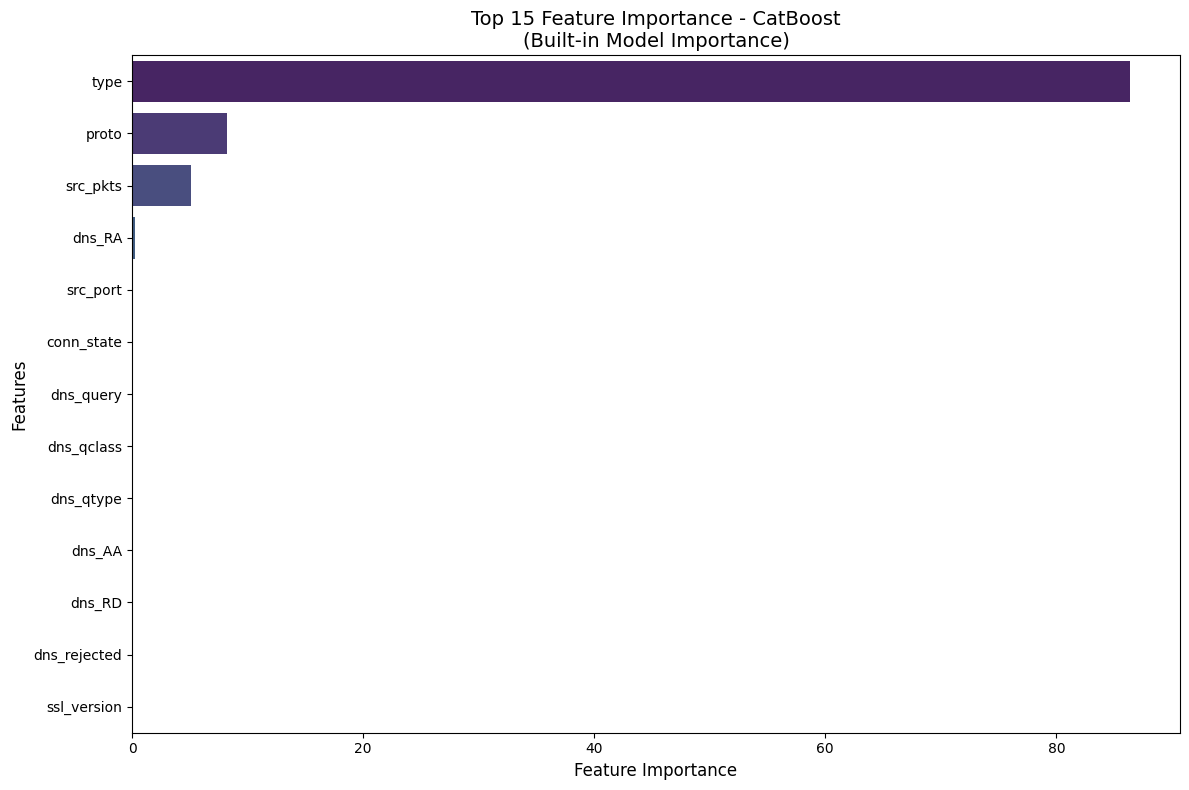

In [11]:
# 5. FEATURE IMPORTANCE ANALYSIS
print("\n5. FEATURE IMPORTANCE ANALYSIS")
print("-" * 50)

# Create directory for plots
os.makedirs('plots', exist_ok=True)

# A. Built-in Feature Importance (for tree-based models)
feature_importance_results = {}

if hasattr(best_model, 'feature_importances_'):
    print("📊 Built-in Feature Importance (from model)")
    builtin_importance = best_model.feature_importances_
    
    # Create DataFrame for better visualization
    importance_df = pd.DataFrame({
        'feature': selected_feature_names,
        'importance': builtin_importance
    }).sort_values('importance', ascending=False)
    
    feature_importance_results['builtin'] = importance_df
    
    print(f"Top 10 most important features:")
    for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
        print(f"  {i:2d}. {row['feature']:<20} : {row['importance']:.4f}")
    
    # Plot built-in importance
    plt.figure(figsize=(12, 8))
    top_features = importance_df.head(15)
    sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
    plt.title(f'Top 15 Feature Importance - {best_model_name}\n(Built-in Model Importance)', fontsize=14)
    plt.xlabel('Feature Importance', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.savefig('plots/builtin_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
else:
    print("⚠️ Model doesn't have built-in feature importance")

print("\n" + "="*60)


📊 Permutation Importance Analysis
----------------------------------------
Computing permutation importance... (this may take a while)
Top 10 features by permutation importance:
   1. type                 : 0.3347 ± 0.0025
   2. src_pkts             : 0.0193 ± 0.0006
   3. src_port             : 0.0000 ± 0.0000
   4. proto                : 0.0000 ± 0.0000
   5. conn_state           : 0.0000 ± 0.0000
   6. dns_query            : 0.0000 ± 0.0000
   7. dns_qclass           : 0.0000 ± 0.0000
   8. dns_qtype            : 0.0000 ± 0.0000
   9. dns_AA               : 0.0000 ± 0.0000
  10. dns_RD               : 0.0000 ± 0.0000


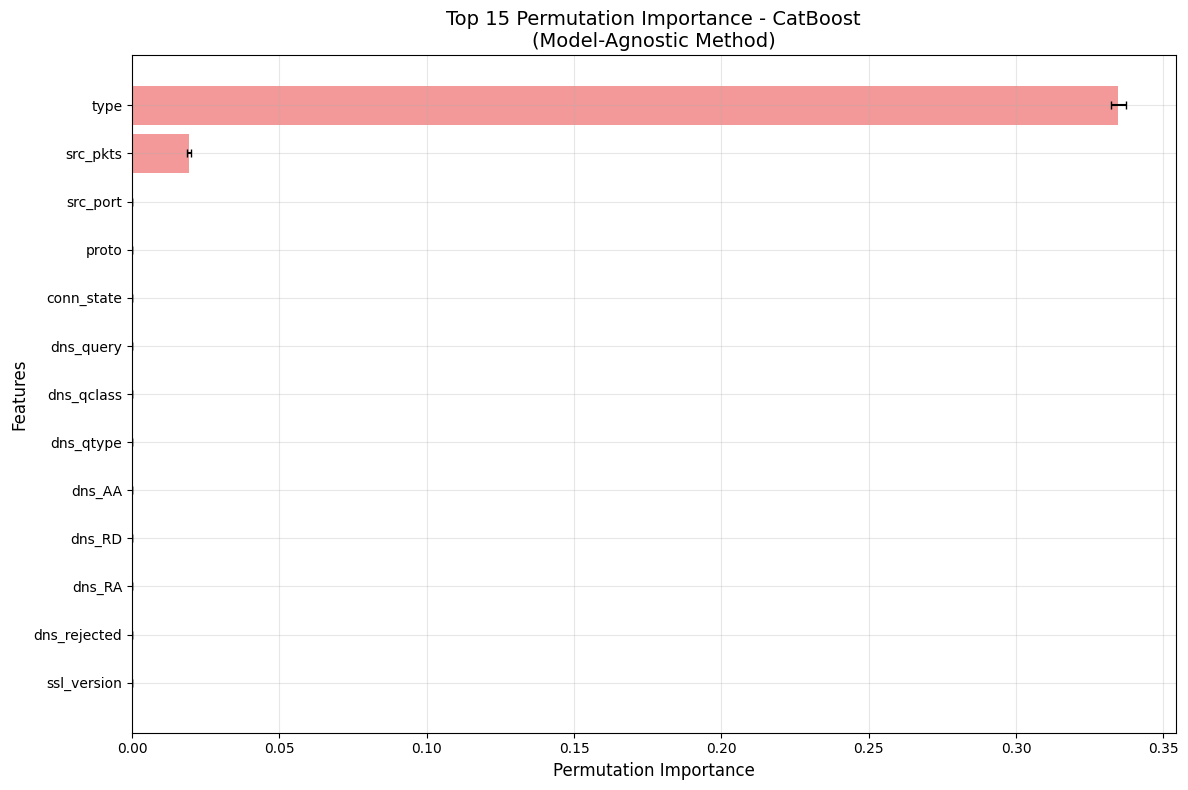

In [12]:
# B. Permutation Importance (model-agnostic)
print("\n📊 Permutation Importance Analysis")
print("-" * 40)

# Calculate permutation importance
print("Computing permutation importance... (this may take a while)")
perm_importance = permutation_importance(
    best_model, X_test_selected, y_test, 
    n_repeats=10, random_state=42, n_jobs=-1
)

# Create DataFrame
perm_importance_df = pd.DataFrame({
    'feature': selected_feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
}).sort_values('importance_mean', ascending=False)

feature_importance_results['permutation'] = perm_importance_df

print(f"Top 10 features by permutation importance:")
for i, (_, row) in enumerate(perm_importance_df.head(10).iterrows(), 1):
    print(f"  {i:2d}. {row['feature']:<20} : {row['importance_mean']:.4f} ± {row['importance_std']:.4f}")

# Plot permutation importance with error bars
plt.figure(figsize=(12, 8))
top_perm_features = perm_importance_df.head(15)
plt.barh(range(len(top_perm_features)), top_perm_features['importance_mean'], 
         xerr=top_perm_features['importance_std'], capsize=3, 
         color='lightcoral', alpha=0.8)
plt.yticks(range(len(top_perm_features)), top_perm_features['feature'])
plt.xlabel('Permutation Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Top 15 Permutation Importance - {best_model_name}\n(Model-Agnostic Method)', fontsize=14)
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('plots/permutation_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*60)


📊 COMPARING IMPORTANCE METHODS
----------------------------------------
Correlation between built-in and permutation importance: 0.9954


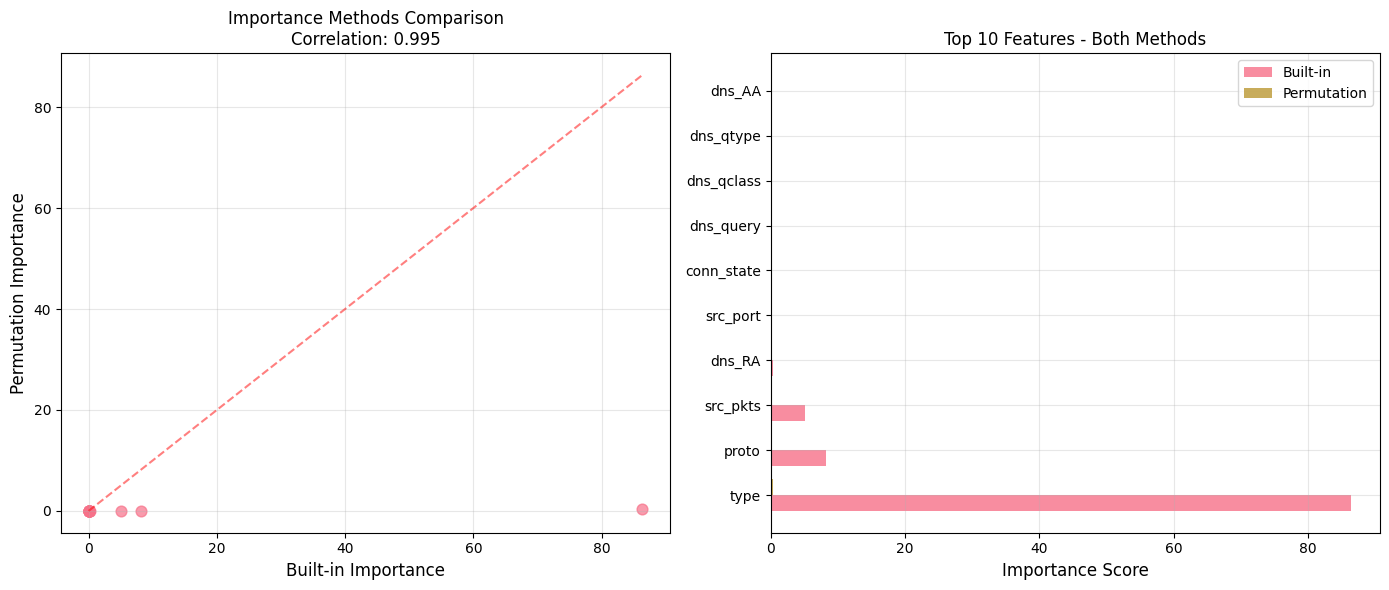

✅ Feature importance analysis completed!
📁 Results saved to: results/ and plots/


In [13]:
# C. Compare Different Importance Methods
print("\n📊 COMPARING IMPORTANCE METHODS")
print("-" * 40)

if 'builtin' in feature_importance_results and 'permutation' in feature_importance_results:
    # Merge both importance measures
    builtin_df = feature_importance_results['builtin'].set_index('feature')
    perm_df = feature_importance_results['permutation'].set_index('feature')
    
    comparison_df = pd.merge(
        builtin_df[['importance']], 
        perm_df[['importance_mean']], 
        left_index=True, right_index=True
    ).rename(columns={
        'importance': 'builtin_importance',
        'importance_mean': 'permutation_importance'
    })
    
    # Calculate correlation between methods
    correlation = comparison_df['builtin_importance'].corr(comparison_df['permutation_importance'])
    print(f"Correlation between built-in and permutation importance: {correlation:.4f}")
    
    # Plot comparison
    plt.figure(figsize=(14, 6))
    
    # Subplot 1: Scatter plot
    plt.subplot(1, 2, 1)
    plt.scatter(comparison_df['builtin_importance'], 
                comparison_df['permutation_importance'], 
                alpha=0.7, s=60)
    plt.xlabel('Built-in Importance', fontsize=12)
    plt.ylabel('Permutation Importance', fontsize=12)
    plt.title(f'Importance Methods Comparison\nCorrelation: {correlation:.3f}', fontsize=12)
    
    # Add diagonal line
    max_val = max(comparison_df['builtin_importance'].max(), 
                  comparison_df['permutation_importance'].max())
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    
    # Subplot 2: Top 10 features side by side
    plt.subplot(1, 2, 2)
    top_10_features = comparison_df.head(10)
    x = np.arange(len(top_10_features))
    width = 0.35
    
    plt.barh(x - width/2, top_10_features['builtin_importance'], 
             width, label='Built-in', alpha=0.8)
    plt.barh(x + width/2, top_10_features['permutation_importance'], 
             width, label='Permutation', alpha=0.8)
    
    plt.yticks(x, [f[:15] + '...' if len(f) > 15 else f for f in top_10_features.index])
    plt.xlabel('Importance Score', fontsize=12)
    plt.title('Top 10 Features - Both Methods', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('plots/importance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("Only permutation importance available for comparison")

# Save importance results
feature_importance_results['permutation'].to_csv('results/permutation_importance.csv', index=False)
if 'builtin' in feature_importance_results:
    feature_importance_results['builtin'].to_csv('results/builtin_importance.csv', index=False)

print("✅ Feature importance analysis completed!")
print("📁 Results saved to: results/ and plots/")



6. PARTIAL DEPENDENCE PLOT ANALYSIS
--------------------------------------------------
Analyzing PDP for top 6 features: ['type', 'src_pkts', 'src_port', 'proto', 'conn_state', 'dns_query']
Feature information:
  type: 10 unique values, categorical: True
  src_pkts: 109 unique values, categorical: False
  src_port: 13347 unique values, categorical: False
  proto: 3 unique values, categorical: True
  conn_state: 13 unique values, categorical: True
  dns_query: 347 unique values, categorical: False


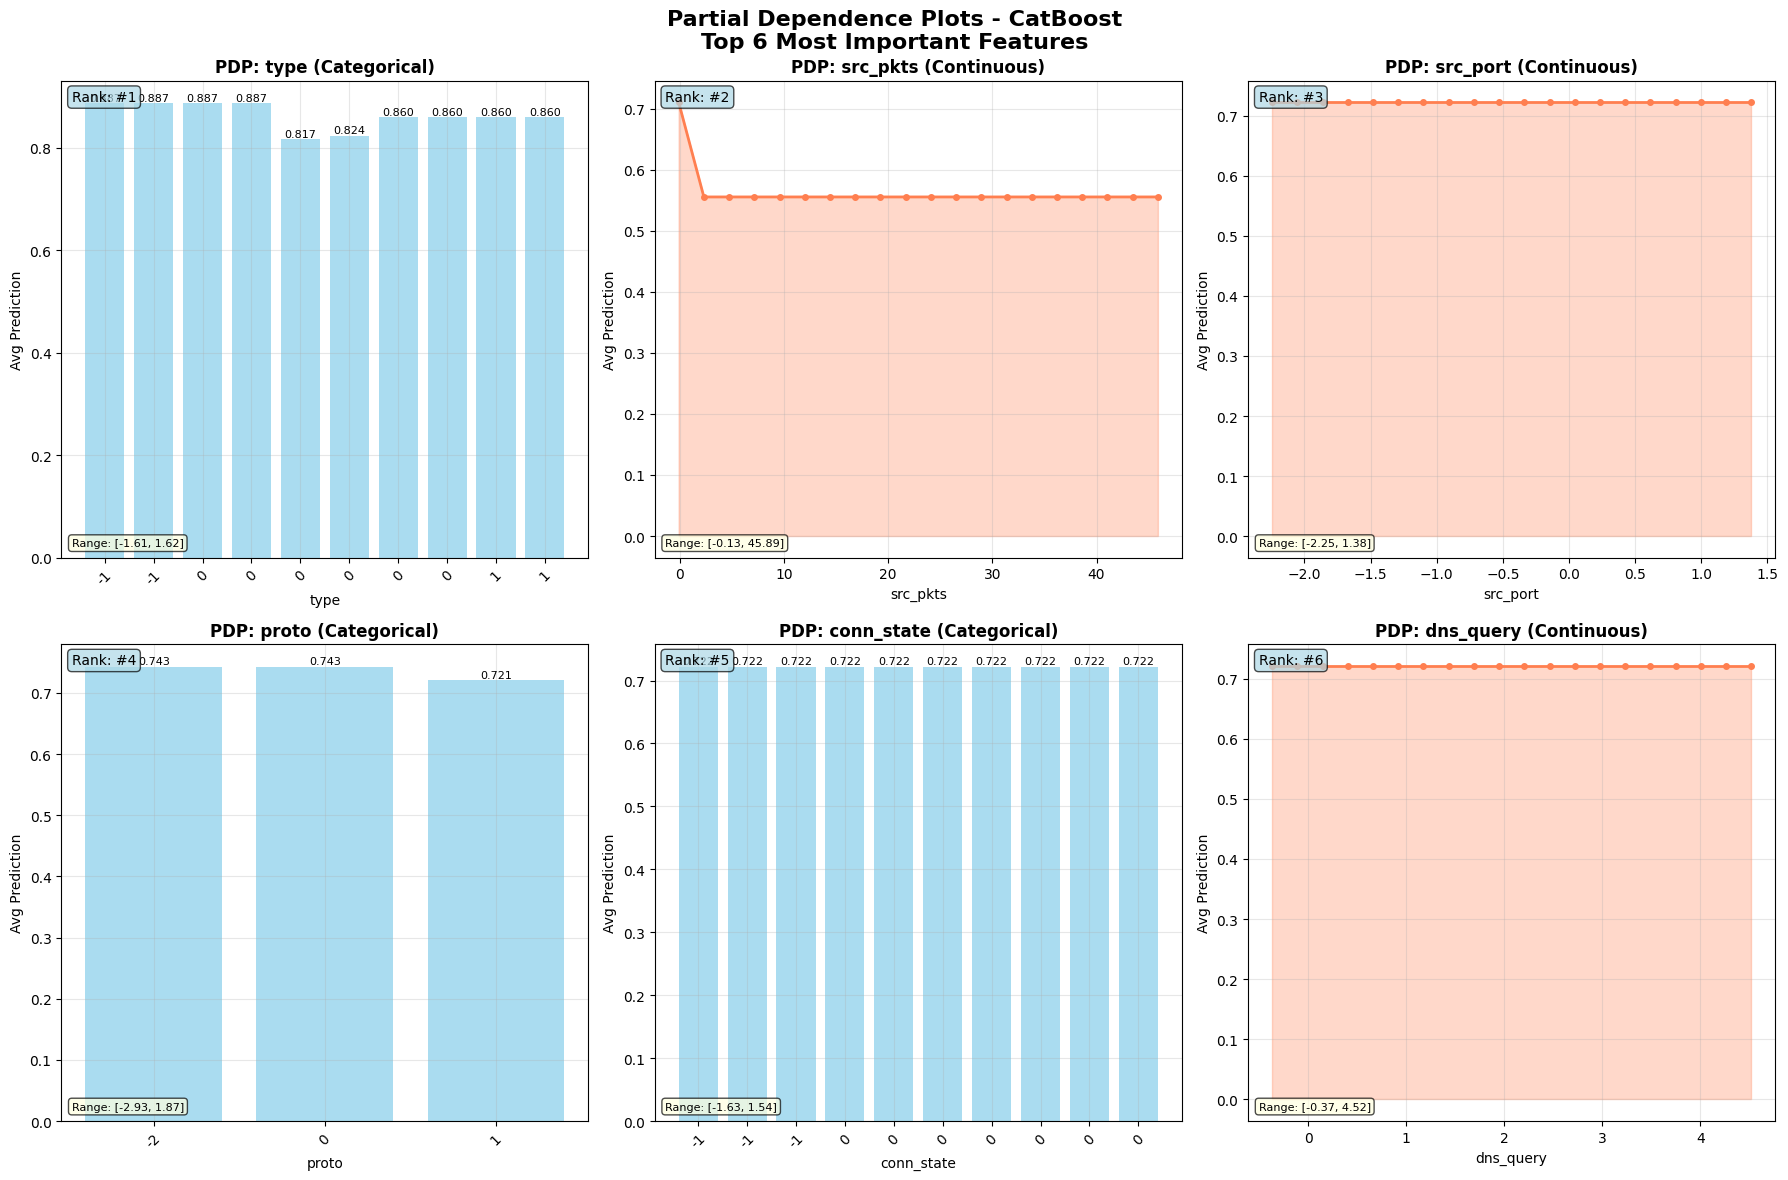

✅ Partial Dependence Plot analysis completed!
📁 PDP plots saved to: plots/partial_dependence_plots_manual.png

📊 FEATURE STATISTICS SUMMARY
----------------------------------------
type:
  Range: [-1.61, 1.62]
  Mean: -0.0103, Std: 1.0015
  Unique values: 10
  Categories: [-1.60823325 -1.24945744 -0.89068163 -0.53190582 -0.17313001  0.1856458
  0.54442161  0.90319742  1.26197323  1.62074904]

src_pkts:
  Range: [-0.13, 45.89]
  Mean: -0.0101, Std: 0.6299
  Unique values: 109

src_port:
  Range: [-2.25, 1.38]
  Mean: 0.0028, Std: 0.9992
  Unique values: 13347

proto:
  Range: [-2.93, 1.87]
  Mean: -0.0000, Std: 0.9985
  Unique values: 3
  Categories: [-2.93024654 -0.52930894  1.87162865]

conn_state:
  Range: [-1.63, 1.54]
  Mean: -0.0074, Std: 1.0045
  Unique values: 13
  Categories: [-1.63153415 -1.36732972 -1.10312529 -0.83892086 -0.57471643 -0.31051201
 -0.04630758  0.21789685  0.48210128  0.74630571]

dns_query:
  Range: [-0.37, 4.52]
  Mean: 0.0008, Std: 0.9974
  Unique values: 34

In [16]:
# 6. PARTIAL DEPENDENCE PLOT ANALYSIS (MANUAL FIX)
print("\n6. PARTIAL DEPENDENCE PLOT ANALYSIS")
print("-" * 50)

# Get top 6 most important features from permutation importance
top_features = feature_importance_results['permutation'].head(6)['feature'].tolist()
print(f"Analyzing PDP for top 6 features: {top_features}")

# Get feature indices and check feature types
feature_indices = []
feature_info = []

for feat in top_features:
    idx = np.where(selected_feature_names == feat)[0]
    if len(idx) > 0:
        feat_idx = idx[0]
        feature_indices.append(feat_idx)
        
        # Check if feature is categorical (few unique values)
        unique_vals = len(np.unique(X_test_selected[:, feat_idx]))
        is_categorical = unique_vals <= 15  # Increased threshold
        
        feature_info.append({
            'name': feat,
            'index': feat_idx,
            'unique_values': unique_vals,
            'is_categorical': is_categorical
        })

print(f"Feature information:")
for info in feature_info:
    print(f"  {info['name']}: {info['unique_values']} unique values, categorical: {info['is_categorical']}")

# Create PDP plots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Manual PDP calculation function
def calculate_pdp_manual(model, X_sample, feature_idx, feature_values, is_categorical=False):
    """Calculate PDP manually for better control"""
    pdp_values = []
    
    for val in feature_values:
        # Create a copy of sample data with this feature value fixed
        X_temp = X_sample.copy()
        X_temp[:, feature_idx] = val
        
        # Get predictions
        if hasattr(model, 'predict_proba'):
            pred_probs = model.predict_proba(X_temp)
            # Use mean probability for the most likely class
            mean_pred = pred_probs.mean(axis=0).max()
        else:
            predictions = model.predict(X_temp)
            mean_pred = predictions.mean()
        
        pdp_values.append(mean_pred)
    
    return np.array(pdp_values)

# Plot individual PDPs with manual calculation
for i, info in enumerate(feature_info):
    feat_idx = info['index']
    feat_name = info['name']
    
    try:
        # Sample data to speed up PDP calculation
        sample_size = min(500, len(X_test_selected))  # Reduced sample size
        sample_indices = np.random.choice(len(X_test_selected), sample_size, replace=False)
        X_sample = X_test_selected[sample_indices]
        
        # Get feature values range
        feat_data = X_test_selected[:, feat_idx]
        
        if info['is_categorical']:
            # For categorical features
            unique_vals = np.unique(feat_data)
            unique_vals = unique_vals[:min(10, len(unique_vals))]  # Limit to 10 categories
            
            pdp_values = calculate_pdp_manual(best_model, X_sample, feat_idx, unique_vals, True)
            
            # Plot bar chart
            bars = axes[i].bar(range(len(unique_vals)), pdp_values, alpha=0.7, color='skyblue')
            axes[i].set_xticks(range(len(unique_vals)))
            axes[i].set_xticklabels([f'{int(v)}' for v in unique_vals], rotation=45)
            axes[i].set_xlabel(feat_name, fontsize=10)
            axes[i].set_ylabel('Avg Prediction', fontsize=10)
            axes[i].set_title(f'PDP: {feat_name} (Categorical)', fontsize=12, fontweight='bold')
            
            # Add value labels on bars
            for bar, val in zip(bars, pdp_values):
                height = bar.get_height()
                axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                           f'{val:.3f}', ha='center', va='bottom', fontsize=8)
            
        else:
            # For continuous features
            feature_range = np.linspace(feat_data.min(), feat_data.max(), 20)
            
            pdp_values = calculate_pdp_manual(best_model, X_sample, feat_idx, feature_range, False)
            
            # Plot line chart
            axes[i].plot(feature_range, pdp_values, linewidth=2, color='coral', marker='o', markersize=4)
            axes[i].fill_between(feature_range, pdp_values, alpha=0.3, color='coral')
            axes[i].set_xlabel(feat_name, fontsize=10)
            axes[i].set_ylabel('Avg Prediction', fontsize=10)
            axes[i].set_title(f'PDP: {feat_name} (Continuous)', fontsize=12, fontweight='bold')
        
        axes[i].grid(True, alpha=0.3)
        
        # Add interpretation text
        axes[i].text(0.02, 0.98, f'Rank: #{i+1}', 
                    transform=axes[i].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
        
        # Add range info
        range_text = f'Range: [{feat_data.min():.2f}, {feat_data.max():.2f}]'
        axes[i].text(0.02, 0.02, range_text, 
                    transform=axes[i].transAxes, fontsize=8,
                    verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
                    
    except Exception as e:
        print(f"Error plotting {feat_name}: {str(e)}")
        axes[i].text(0.5, 0.5, f'Error plotting {feat_name}:\n{str(e)[:60]}...', 
                    ha='center', va='center', transform=axes[i].transAxes,
                    fontsize=10, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
        axes[i].set_title(f'PDP: {feat_name} (Error)', fontsize=12)

plt.suptitle(f'Partial Dependence Plots - {best_model_name}\nTop 6 Most Important Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/partial_dependence_plots_manual.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Partial Dependence Plot analysis completed!")
print("📁 PDP plots saved to: plots/partial_dependence_plots_manual.png")

# Feature statistics summary
print(f"\n📊 FEATURE STATISTICS SUMMARY")
print("-" * 40)
for info in feature_info:
    feat_idx = info['index']
    feat_data = X_test_selected[:, feat_idx]
    print(f"{info['name']}:")
    print(f"  Range: [{feat_data.min():.2f}, {feat_data.max():.2f}]")
    print(f"  Mean: {feat_data.mean():.4f}, Std: {feat_data.std():.4f}")
    print(f"  Unique values: {info['unique_values']}")
    if info['is_categorical']:
        unique_vals = np.unique(feat_data)[:10]
        print(f"  Categories: {unique_vals}")
    print()

In [18]:
# 7. SHAP ANALYSIS - Advanced Explainability
print("\n7. SHAP ANALYSIS")
print("-" * 50)


# Initialize SHAP explainer based on model type
print(f"Initializing SHAP explainer for {type(best_model).__name__}...")

# Sample data for SHAP (to speed up computation)
sample_size = min(500, len(X_test_selected))
sample_indices = np.random.choice(len(X_test_selected), sample_size, replace=False)
X_shap_sample = X_test_selected[sample_indices]

# Fix: Convert y_test to numpy array first, then sample
y_test_array = np.array(y_test)  # Convert to numpy array
y_shap_sample = y_test_array[sample_indices]  # Now this will work

print(f"Using {sample_size} samples for SHAP analysis")

# Choose appropriate SHAP explainer
if hasattr(best_model, 'predict_proba'):
    # For tree-based models (CatBoost, RandomForest, etc.)
    if 'CatBoost' in str(type(best_model)) or 'RandomForest' in str(type(best_model)):
        explainer = shap.TreeExplainer(best_model)
        print("Using TreeExplainer (optimal for tree-based models)")
    else:
        # For other models with predict_proba
        explainer = shap.KernelExplainer(best_model.predict_proba, X_shap_sample[:100])
        print("Using KernelExplainer (model-agnostic)")
else:
    # For models without predict_proba
    explainer = shap.KernelExplainer(best_model.predict, X_shap_sample[:100])
    print("Using KernelExplainer for regression/prediction")

print("SHAP explainer initialized successfully!")


7. SHAP ANALYSIS
--------------------------------------------------
Initializing SHAP explainer for CatBoostClassifier...
Using 500 samples for SHAP analysis
Using TreeExplainer (optimal for tree-based models)
SHAP explainer initialized successfully!


In [21]:
# A. Calculate SHAP values
print("\n📊 CALCULATING SHAP VALUES")
print("-" * 40)

print("Computing SHAP values... (this may take several minutes)")
start_time = time.time()

# Calculate SHAP values
shap_values = explainer.shap_values(X_shap_sample)

# Handle different output formats
if isinstance(shap_values, list):
    # Multi-class case - use values for positive class or average
    if len(shap_values) == 2:  # Binary classification
        shap_values_to_plot = shap_values[1]  # Positive class
        print("Using SHAP values for positive class (binary classification)")
    else:  # Multi-class
        shap_values_to_plot = shap_values[0]  # First class or average
        print(f"Using SHAP values for first class (multi-class with {len(shap_values)} classes)")
else:
    # Single output case
    shap_values_to_plot = shap_values
    print("Using SHAP values (single output)")

end_time = time.time()
print(f"SHAP computation completed in {end_time - start_time:.2f} seconds")
print(f"SHAP values shape: {shap_values_to_plot.shape}")


📊 CALCULATING SHAP VALUES
----------------------------------------
Computing SHAP values... (this may take several minutes)
Using SHAP values (single output)
SHAP computation completed in 0.30 seconds
SHAP values shape: (500, 13)



📊 SHAP SUMMARY PLOTS
----------------------------------------


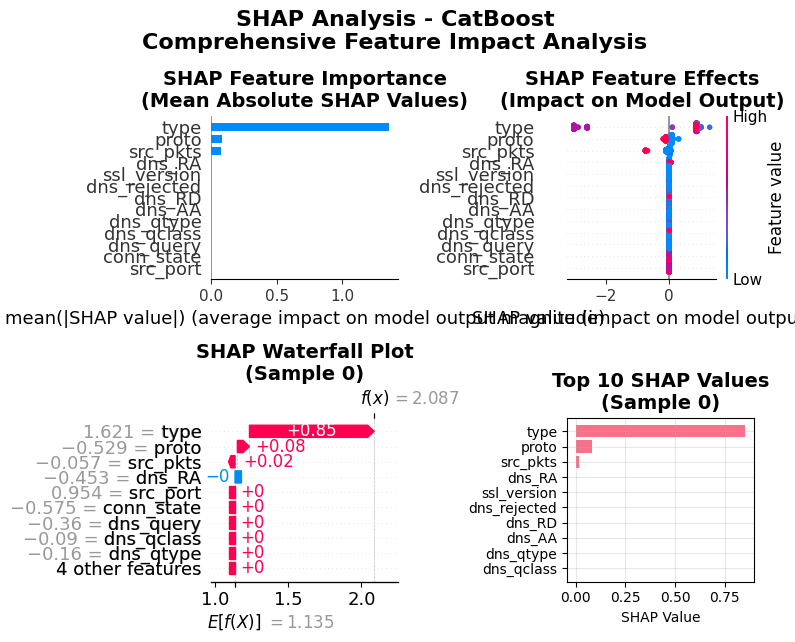

✅ SHAP summary plots completed!


In [22]:
# B. SHAP Summary Plots
print("\n📊 SHAP SUMMARY PLOTS")
print("-" * 40)

# Create feature names for SHAP plots
feature_names_for_shap = [str(name) for name in selected_feature_names]

fig, axes = plt.subplots(2, 2, figsize=(20, 16))

# 1. Summary Plot (Feature Importance)
plt.subplot(2, 2, 1)
shap.summary_plot(shap_values_to_plot, X_shap_sample, 
                  feature_names=feature_names_for_shap, 
                  plot_type="bar", show=False, max_display=15)
plt.title('SHAP Feature Importance\n(Mean Absolute SHAP Values)', fontsize=14, fontweight='bold')

# 2. Summary Plot (Feature Effects)
plt.subplot(2, 2, 2)
shap.summary_plot(shap_values_to_plot, X_shap_sample, 
                  feature_names=feature_names_for_shap, 
                  show=False, max_display=15)
plt.title('SHAP Feature Effects\n(Impact on Model Output)', fontsize=14, fontweight='bold')

# 3. Waterfall plot for a single prediction
plt.subplot(2, 2, 3)
sample_idx = 0  # First sample
if hasattr(explainer, 'expected_value'):
    expected_value = explainer.expected_value
    if isinstance(expected_value, np.ndarray):
        expected_value = expected_value[0] if len(expected_value) > 0 else 0
else:
    expected_value = 0

shap.waterfall_plot(shap.Explanation(values=shap_values_to_plot[sample_idx], 
                                    base_values=expected_value,
                                    data=X_shap_sample[sample_idx],
                                    feature_names=feature_names_for_shap),
                   show=False, max_display=10)
plt.title(f'SHAP Waterfall Plot\n(Sample {sample_idx})', fontsize=14, fontweight='bold')

# 4. Force plot (alternative visualization)
plt.subplot(2, 2, 4)
# Create a simple force plot alternative
top_features_shap = np.argsort(np.abs(shap_values_to_plot[sample_idx]))[-10:]
plt.barh(range(len(top_features_shap)), 
         shap_values_to_plot[sample_idx][top_features_shap])
plt.yticks(range(len(top_features_shap)), 
           [feature_names_for_shap[i] for i in top_features_shap])
plt.xlabel('SHAP Value')
plt.title(f'Top 10 SHAP Values\n(Sample {sample_idx})', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.suptitle(f'SHAP Analysis - {best_model_name}\nComprehensive Feature Impact Analysis', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/shap_analysis_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ SHAP summary plots completed!")


8. FEATURE INTERACTION ANALYSIS
--------------------------------------------------


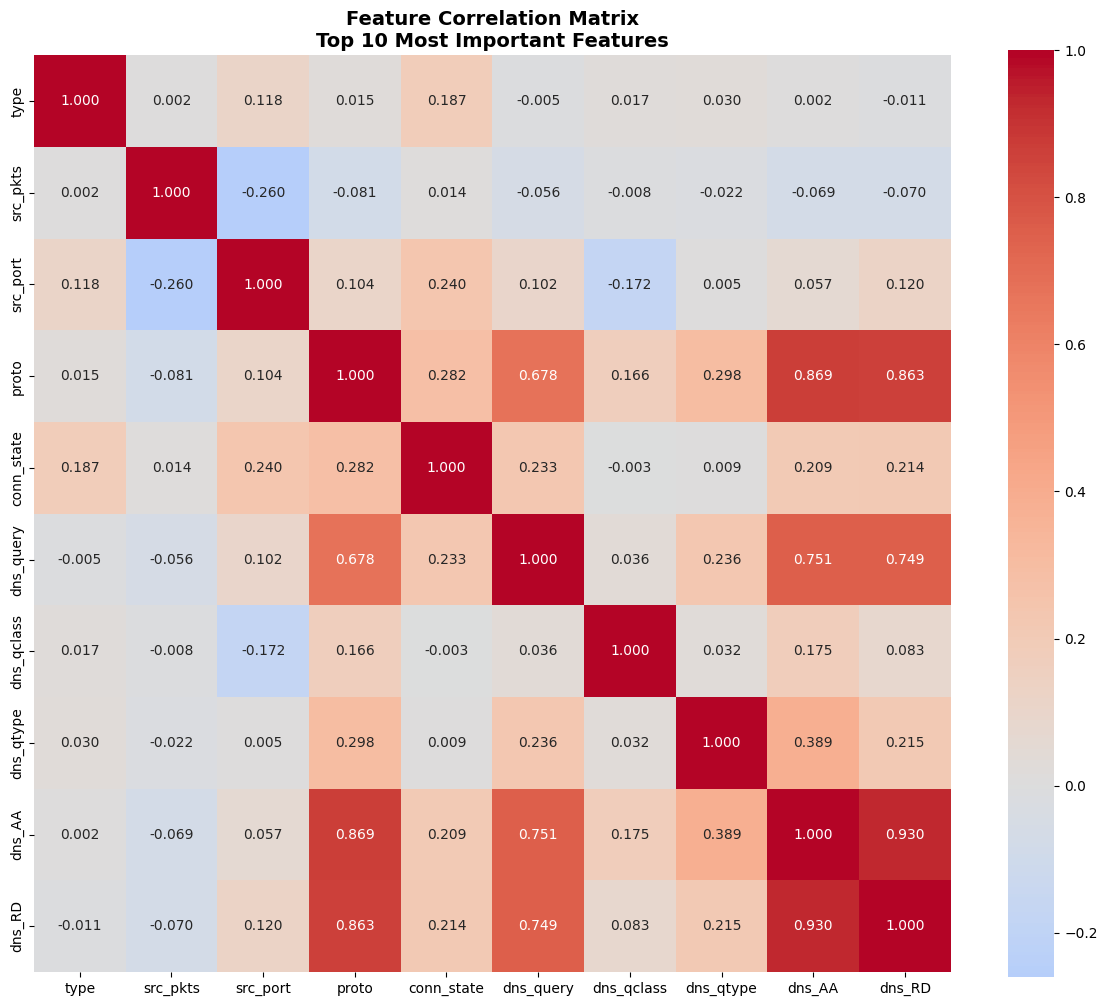


📊 SHAP INTERACTION VALUES
Computing SHAP interaction values...


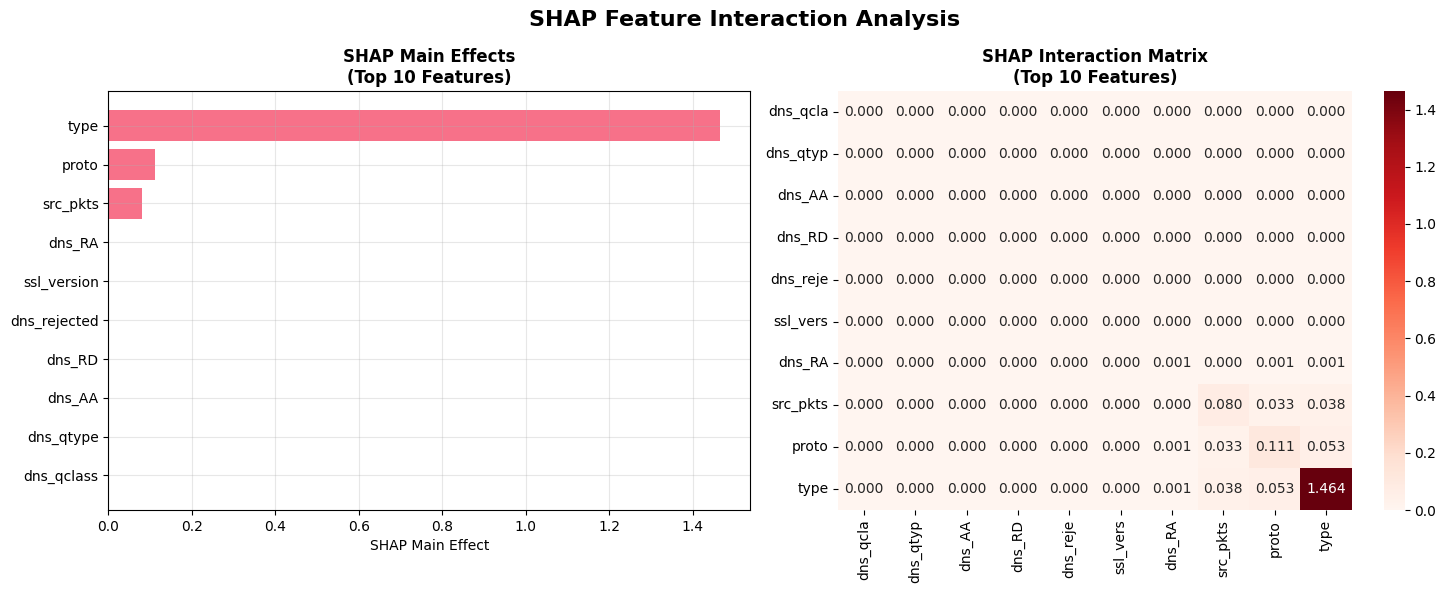

✅ SHAP interaction analysis completed!
✅ Feature interaction analysis completed!


In [25]:
# 8. FEATURE INTERACTION ANALYSIS
print("\n8. FEATURE INTERACTION ANALYSIS")
print("-" * 50)

# A. Feature Correlation Heatmap for Top Features
top_10_features = feature_importance_results['permutation'].head(10)['feature'].tolist()
top_10_indices = [np.where(selected_feature_names == feat)[0][0] for feat in top_10_features]

# Get correlation matrix for top features
top_features_data = X_test_selected[:, top_10_indices]
correlation_matrix = np.corrcoef(top_features_data.T)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            xticklabels=top_10_features,
            yticklabels=top_10_features,
            annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title(f'Feature Correlation Matrix\nTop 10 Most Important Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/feature_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# B. SHAP Interaction Values (if TreeExplainer)
if 'TreeExplainer' in str(type(explainer)):
    print("\n📊 SHAP INTERACTION VALUES")
    print("Computing SHAP interaction values...")
    
    # Sample smaller dataset for interaction analysis
    interaction_sample_size = min(100, len(X_shap_sample))
    interaction_indices = np.random.choice(len(X_shap_sample), interaction_sample_size, replace=False)
    X_interaction_sample = X_shap_sample[interaction_indices]
    
    try:
        shap_interaction_values = explainer.shap_interaction_values(X_interaction_sample)
        
        # Plot interaction for top features
        plt.figure(figsize=(15, 6))
        
        # Subplot 1: Main effects
        plt.subplot(1, 2, 1)
        main_effects = np.abs(shap_interaction_values).mean(0).diagonal()
        top_main_indices = np.argsort(main_effects)[-10:]
        
        plt.barh(range(len(top_main_indices)), main_effects[top_main_indices])
        plt.yticks(range(len(top_main_indices)), 
                   [feature_names_for_shap[i] for i in top_main_indices])
        plt.xlabel('SHAP Main Effect')
        plt.title('SHAP Main Effects\n(Top 10 Features)', fontweight='bold')
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: Interaction effects heatmap
        plt.subplot(1, 2, 2)
        interaction_matrix = np.abs(shap_interaction_values).mean(0)
        top_feat_interaction = interaction_matrix[top_main_indices][:, top_main_indices]
        
        sns.heatmap(top_feat_interaction, 
                    xticklabels=[feature_names_for_shap[i][:8] for i in top_main_indices],
                    yticklabels=[feature_names_for_shap[i][:8] for i in top_main_indices],
                    annot=True, fmt='.3f', cmap='Reds')
        plt.title('SHAP Interaction Matrix\n(Top 10 Features)', fontweight='bold')
        
        plt.suptitle('SHAP Feature Interaction Analysis', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('plots/shap_interaction_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("✅ SHAP interaction analysis completed!")
        
    except Exception as e:
        print(f"⚠️ SHAP interaction analysis failed: {str(e)}")
        print("Continuing with other analyses...")

print("✅ Feature interaction analysis completed!")

In [26]:
# 9. MODEL INTERPRETATION SUMMARY
print("\n9. MODEL INTERPRETATION SUMMARY")
print("=" * 60)

# Create comprehensive summary report
summary_report = {
    'model_performance': {
        'model_name': best_model_name,
        'test_accuracy': test_accuracy,
        'test_f1_score': test_f1
    },
    'feature_analysis': {
        'total_features_selected': len(selected_feature_names),
        'top_5_features': feature_importance_results['permutation'].head(5)['feature'].tolist(),
        'importance_correlation': correlation if 'builtin' in feature_importance_results else None
    }
}

print("🎯 MODEL PERFORMANCE SUMMARY")
print("-" * 40)
print(f"Best Model: {summary_report['model_performance']['model_name']}")
print(f"Test Accuracy: {summary_report['model_performance']['test_accuracy']:.4f}")
print(f"Test F1-Score: {summary_report['model_performance']['test_f1_score']:.4f}")

print(f"\n🔍 FEATURE ANALYSIS SUMMARY")
print("-" * 40)
print(f"Total Selected Features: {summary_report['feature_analysis']['total_features_selected']}")
print(f"Top 5 Most Important Features:")
for i, feat in enumerate(summary_report['feature_analysis']['top_5_features'], 1):
    importance_val = feature_importance_results['permutation'].iloc[i-1]['importance_mean']
    print(f"  {i}. {feat}: {importance_val:.4f}")

if summary_report['feature_analysis']['importance_correlation']:
    print(f"Feature Importance Correlation: {summary_report['feature_analysis']['importance_correlation']:.4f}")

print(f"\n📊 KEY INSIGHTS FOR CYBERSECURITY")
print("-" * 40)

# Generate cybersecurity insights based on top features
cyber_insights = []
top_features = feature_importance_results['permutation'].head(5)['feature'].tolist()

for feat in top_features:
    if 'type' in feat.lower():
        cyber_insights.append("• Traffic type classification is the most critical factor for attack detection")
    elif 'src' in feat.lower() or 'port' in feat.lower():
        cyber_insights.append("• Source-based features (packets, ports) are key indicators of malicious activity")
    elif 'dns' in feat.lower():
        cyber_insights.append("• DNS-related features help identify DNS-based attacks and anomalies")
    elif 'proto' in feat.lower():
        cyber_insights.append("• Protocol analysis is essential for network security monitoring")
    elif 'conn' in feat.lower():
        cyber_insights.append("• Connection state patterns reveal attack behaviors")

for insight in set(cyber_insights):  # Remove duplicates
    print(insight)

# Save summary to file
import json
os.makedirs('results', exist_ok=True)
with open('results/xai_analysis_summary.json', 'w') as f:
    # Convert numpy types to native Python types for JSON serialization
    summary_json = {
        'model_performance': {
            'model_name': str(summary_report['model_performance']['model_name']),
            'test_accuracy': float(summary_report['model_performance']['test_accuracy']),
            'test_f1_score': float(summary_report['model_performance']['test_f1_score'])
        },
        'feature_analysis': {
            'total_features_selected': int(summary_report['feature_analysis']['total_features_selected']),
            'top_5_features': summary_report['feature_analysis']['top_5_features'],
            'importance_correlation': float(summary_report['feature_analysis']['importance_correlation']) if summary_report['feature_analysis']['importance_correlation'] else None
        },
        'cybersecurity_insights': list(set(cyber_insights))
    }
    json.dump(summary_json, f, indent=2)

print(f"\n✅ XAI Analysis completed successfully!")
print(f"📁 Summary saved to: results/xai_analysis_summary.json")
print(f"📊 All plots saved to: plots/ directory")


9. MODEL INTERPRETATION SUMMARY
🎯 MODEL PERFORMANCE SUMMARY
----------------------------------------
Best Model: CatBoost
Test Accuracy: 1.0000
Test F1-Score: 1.0000

🔍 FEATURE ANALYSIS SUMMARY
----------------------------------------
Total Selected Features: 13
Top 5 Most Important Features:
  1. type: 0.3347
  2. src_pkts: 0.0193
  3. src_port: 0.0000
  4. proto: 0.0000
  5. conn_state: 0.0000
Feature Importance Correlation: 0.9954

📊 KEY INSIGHTS FOR CYBERSECURITY
----------------------------------------
• Traffic type classification is the most critical factor for attack detection
• Source-based features (packets, ports) are key indicators of malicious activity
• Protocol analysis is essential for network security monitoring
• Connection state patterns reveal attack behaviors

✅ XAI Analysis completed successfully!
📁 Summary saved to: results/xai_analysis_summary.json
📊 All plots saved to: plots/ directory



10. LIME ANALYSIS - Local Explainability
--------------------------------------------------
Initializing LIME explainer...
LIME explainer initialized successfully!

Selecting diverse samples for LIME explanation...
Available test samples: 0 to 27538
Selected 6 samples for LIME explanation: [23026, 6709, 11673, 5932, 6551, 10740]
Explaining sample 1 (idx=23026): True=0, Pred=0, Conf=0.887
Explaining sample 2 (idx=6709): True=0, Pred=0, Conf=0.887
Explaining sample 3 (idx=11673): True=0, Pred=0, Conf=0.887
Explaining sample 4 (idx=5932): True=1, Pred=1, Conf=0.890
Explaining sample 5 (idx=6551): True=1, Pred=1, Conf=0.890
Explaining sample 6 (idx=10740): True=1, Pred=1, Conf=0.890


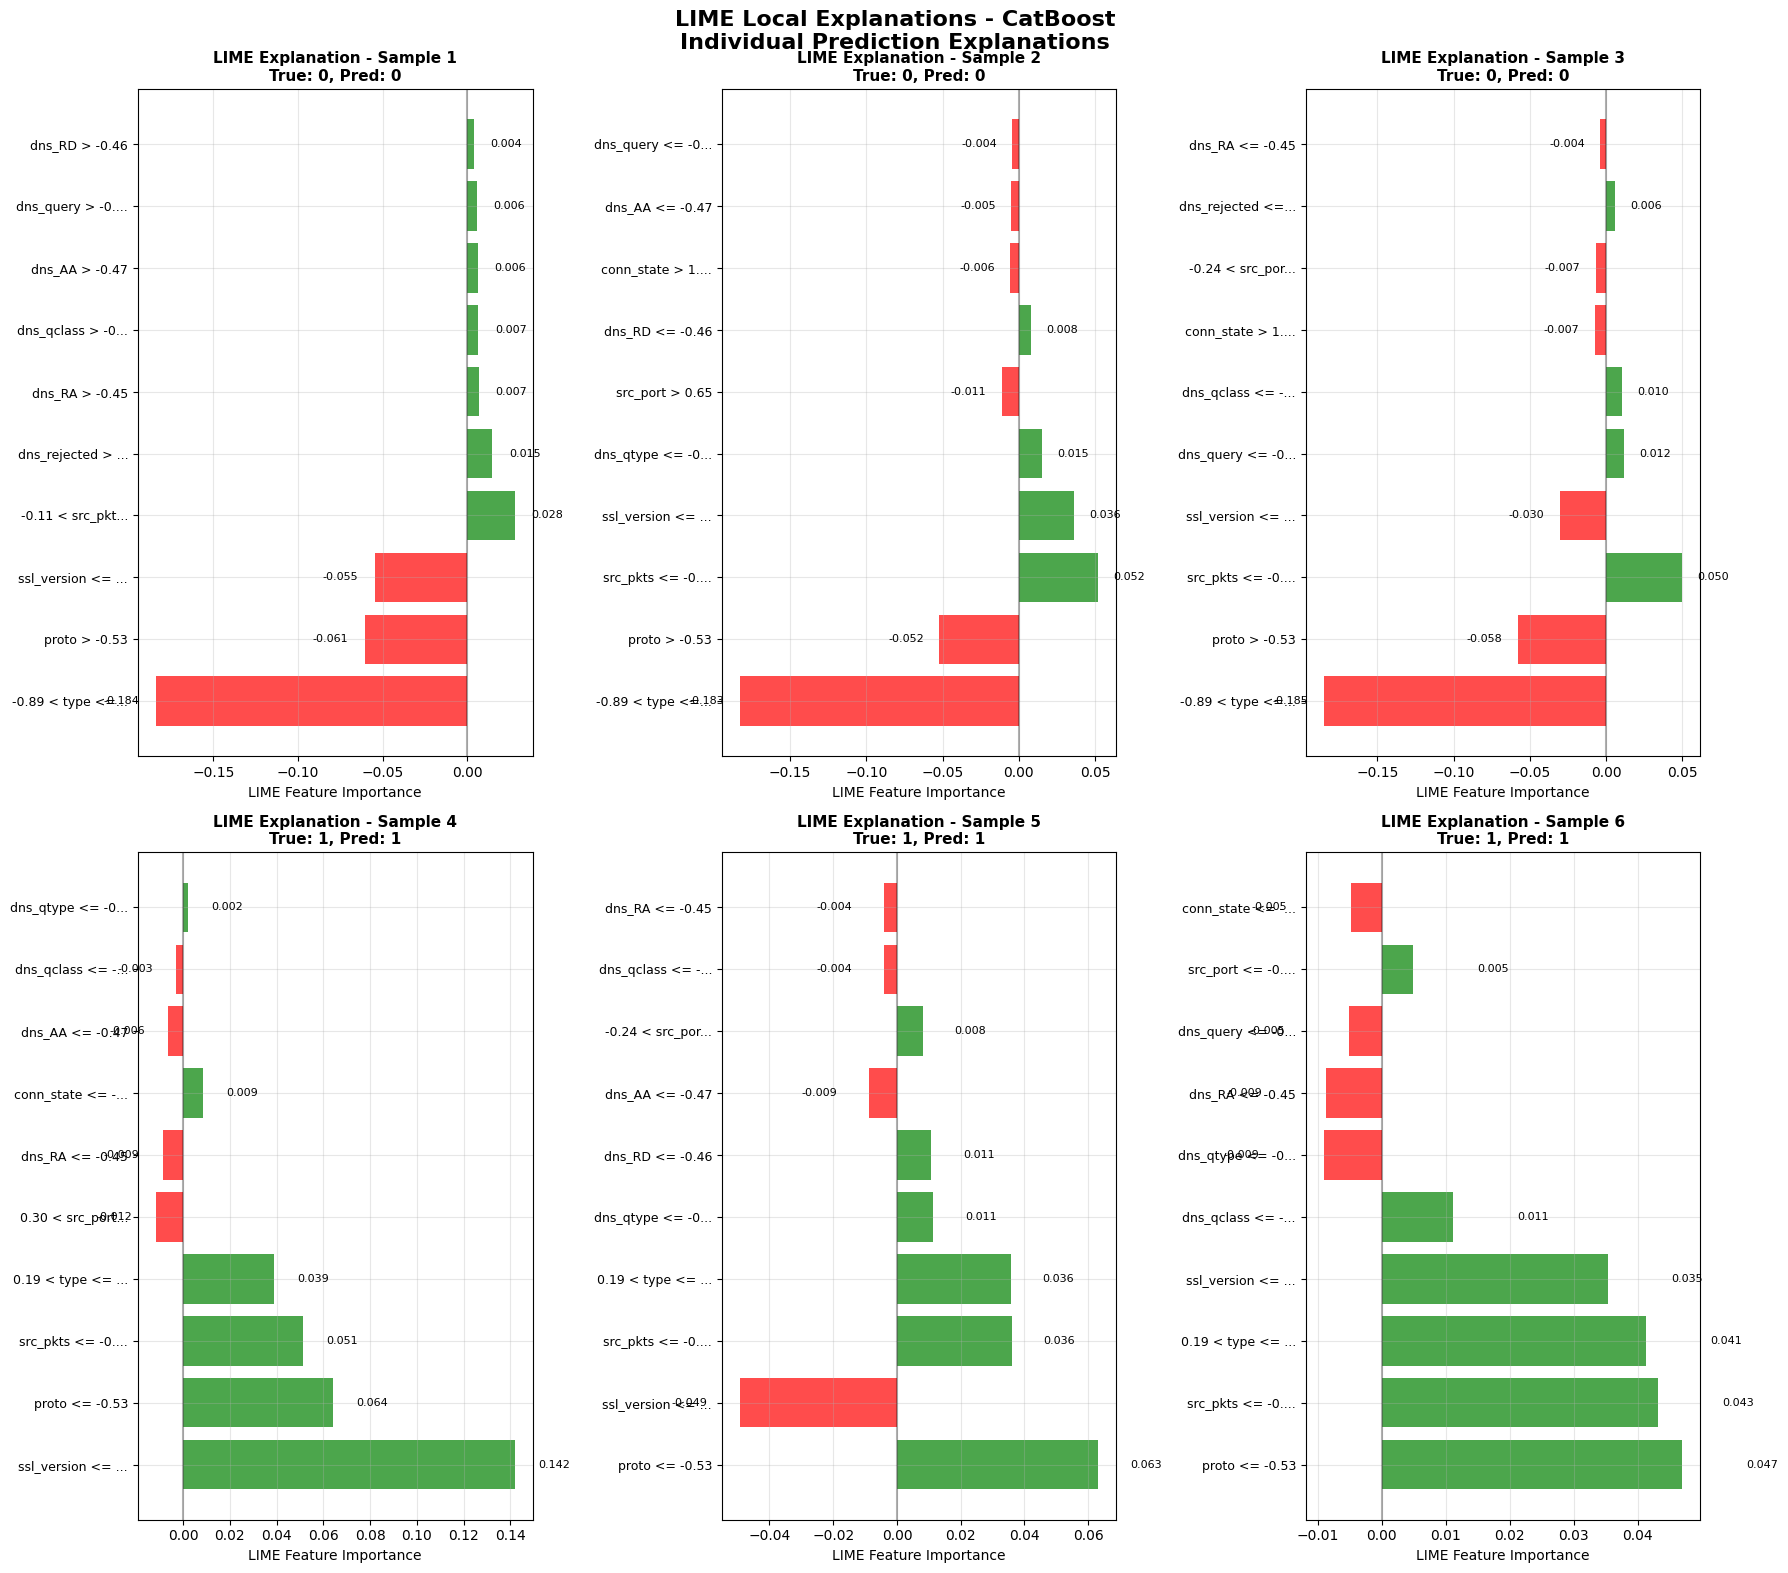

✅ LIME local explanations completed!


In [33]:
# 10. LIME ANALYSIS - Local Explainability (FIXED)
print("\n10. LIME ANALYSIS - Local Explainability")
print("-" * 50)

# Initialize LIME explainer
print("Initializing LIME explainer...")
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train_selected,
    feature_names=selected_feature_names,
    class_names=['Normal', 'Attack'] if len(np.unique(y_test)) == 2 else [f'Class_{i}' for i in range(len(np.unique(y_test)))],
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

print("LIME explainer initialized successfully!")

# Select diverse samples for explanation
print("\nSelecting diverse samples for LIME explanation...")

# FIX: Convert y_test to numpy array and use proper indexing
y_test_array = np.array(y_test)
unique_classes = np.unique(y_test_array)
sample_indices = []

# Get valid indices (0 to len(X_test_selected)-1)
max_test_idx = len(X_test_selected) - 1
print(f"Available test samples: 0 to {max_test_idx}")

for class_label in unique_classes:
    # Find indices where y_test equals this class
    class_mask = (y_test_array == class_label)
    class_indices = np.where(class_mask)[0]
    
    # Filter valid indices (within X_test_selected range)
    valid_class_indices = class_indices[class_indices <= max_test_idx]
    
    if len(valid_class_indices) > 0:
        # Pick 3 samples from each class to get 6 total
        selected = np.random.choice(valid_class_indices, min(3, len(valid_class_indices)), replace=False)
        sample_indices.extend(selected)

sample_indices = sample_indices[:6]  # Ensure we have exactly 6 samples
print(f"Selected {len(sample_indices)} samples for LIME explanation: {sample_indices}")

# Determine subplot layout based on number of samples
n_samples = len(sample_indices)
if n_samples <= 3:
    nrows, ncols = 1, n_samples
elif n_samples <= 6:
    nrows, ncols = 2, 3
else:
    nrows, ncols = 3, 3

# Generate LIME explanations
fig, axes = plt.subplots(nrows, ncols, figsize=(6*ncols, 8*nrows))

# Handle case where we have only one row or one sample
if n_samples == 1:
    axes = [axes]
elif nrows == 1:
    axes = axes if n_samples > 1 else [axes]
else:
    axes = axes.flatten()

for i, sample_idx in enumerate(sample_indices):
    # Ensure sample_idx is valid
    if sample_idx >= len(X_test_selected) or sample_idx >= len(y_test_array):
        print(f"Skipping invalid sample index {sample_idx}")
        axes[i].text(0.5, 0.5, f'Invalid sample index\n{sample_idx}', 
                    ha='center', va='center', transform=axes[i].transAxes,
                    fontsize=12, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
        axes[i].set_title(f'LIME - Sample {i+1} (Invalid Index)', fontsize=11)
        continue
    
    sample_data = X_test_selected[sample_idx]
    true_label = y_test_array[sample_idx]  # Use numpy array
    predicted_label = best_model.predict([sample_data])[0]
    
    # Get prediction probabilities
    if hasattr(best_model, 'predict_proba'):
        pred_proba = best_model.predict_proba([sample_data])[0]
        confidence = pred_proba.max()
    else:
        confidence = "N/A"
    
    print(f"Explaining sample {i+1} (idx={sample_idx}): True={true_label}, Pred={predicted_label}, Conf={confidence:.3f}")
    
    try:
        # Generate LIME explanation
        explanation = lime_explainer.explain_instance(
            sample_data, 
            best_model.predict_proba if hasattr(best_model, 'predict_proba') else best_model.predict,
            num_features=10
        )
        
        # Extract feature importance from explanation
        lime_features = []
        lime_values = []
        
        for feature, value in explanation.as_list():
            lime_features.append(feature)
            lime_values.append(value)
        
        # Plot LIME explanation
        colors = ['red' if v < 0 else 'green' for v in lime_values]
        bars = axes[i].barh(range(len(lime_features)), lime_values, color=colors, alpha=0.7)
        
        axes[i].set_yticks(range(len(lime_features)))
        axes[i].set_yticklabels([f[:15] + '...' if len(f) > 15 else f for f in lime_features], fontsize=9)
        axes[i].set_xlabel('LIME Feature Importance', fontsize=10)
        axes[i].set_title(f'LIME Explanation - Sample {i+1}\nTrue: {true_label}, Pred: {predicted_label}', 
                         fontsize=11, fontweight='bold')
        axes[i].grid(True, alpha=0.3)
        axes[i].axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Add value labels on bars
        for bar, val in zip(bars, lime_values):
            width = bar.get_width()
            axes[i].text(width + (0.01 if width >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
                        f'{val:.3f}', ha='left' if width >= 0 else 'right', va='center', fontsize=8)
                        
    except Exception as e:
        print(f"Error generating LIME explanation for sample {i+1}: {str(e)}")
        axes[i].text(0.5, 0.5, f'Error generating\nLIME explanation:\n{str(e)[:50]}...', 
                    ha='center', va='center', transform=axes[i].transAxes,
                    fontsize=10, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.7))
        axes[i].set_title(f'LIME - Sample {i+1} (Error)', fontsize=11)

# Hide empty subplots if we have fewer samples than subplots
if n_samples < nrows * ncols:
    for j in range(n_samples, nrows * ncols):
        if j < len(axes):
            axes[j].set_visible(False)

plt.suptitle(f'LIME Local Explanations - {best_model_name}\nIndividual Prediction Explanations', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('plots/lime_local_explanations.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ LIME local explanations completed!")


11. LIME vs SHAP COMPARISON
--------------------------------------------------
Comparing LIME vs SHAP for sample index 23026


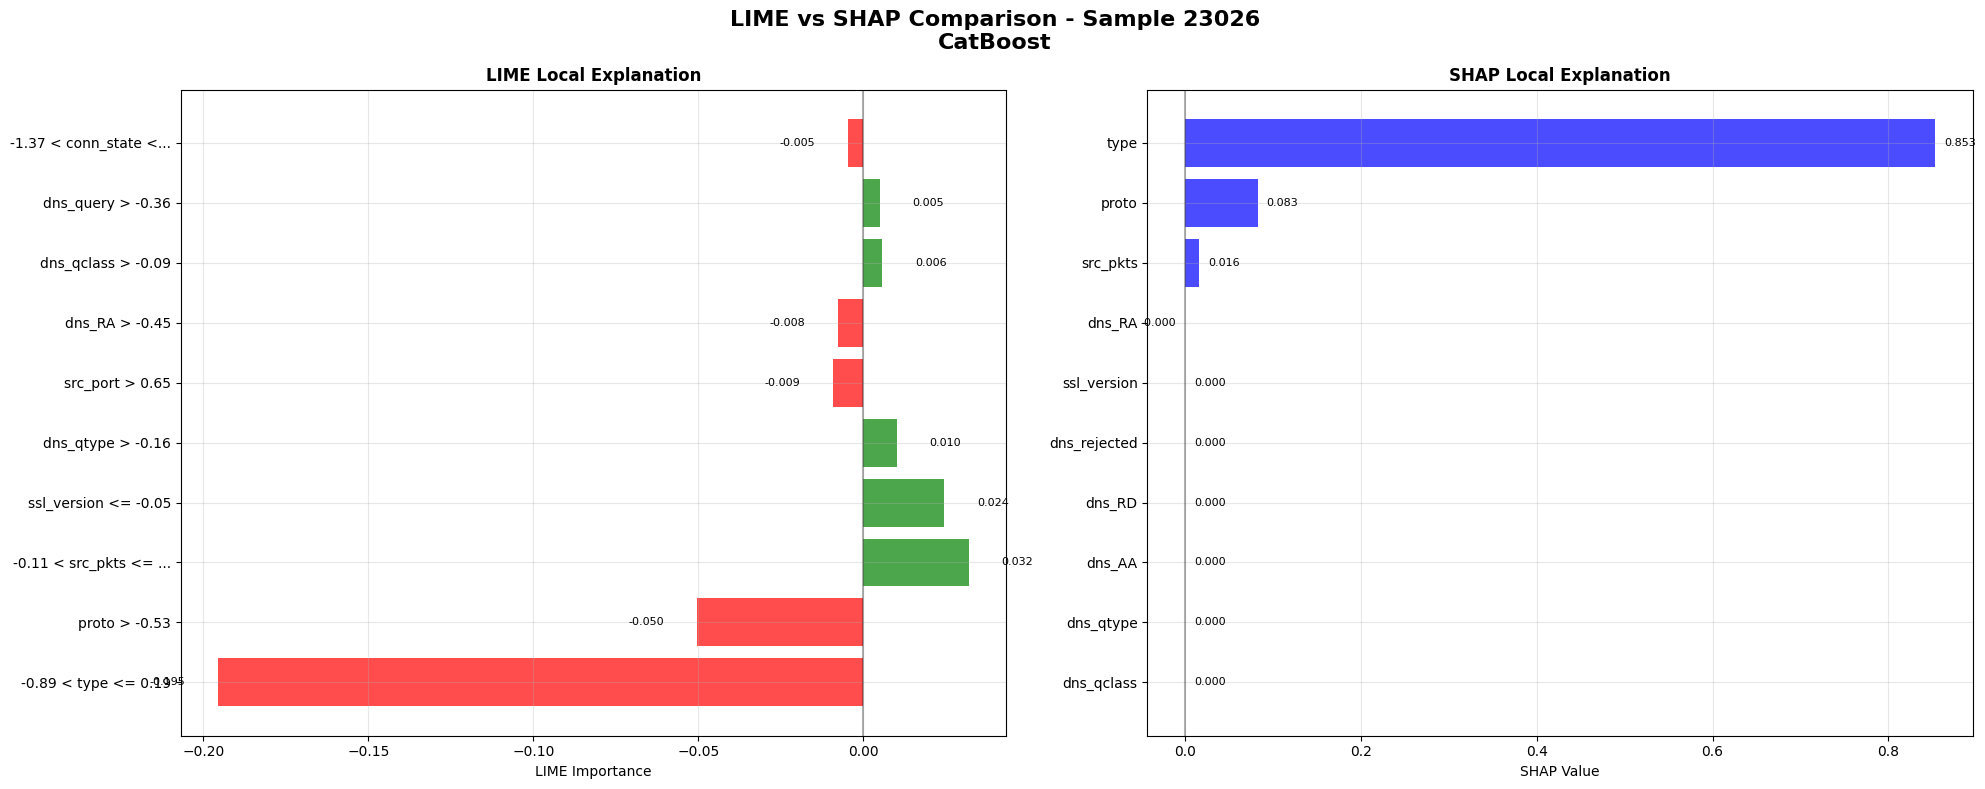

✅ LIME vs SHAP comparison completed!

📊 COMPARISON SUMMARY:
Sample Index: 23026
True Label: 0
Predicted Label: 0

Top 5 LIME Features:
  1. -0.89 < type <= 0.19: -0.1954
  2. proto > -0.53: -0.0505
  3. -0.11 < src_pkts <= -0.10: 0.0319
  4. ssl_version <= -0.05: 0.0245
  5. dns_qtype > -0.16: 0.0101

Top 5 SHAP Features:
  1. type: 0.8532
  2. proto: 0.0827
  3. src_pkts: 0.0162
  4. dns_RA: -0.0000
  5. ssl_version: 0.0000
✅ LIME analysis completed!


In [35]:
# 11. LIME vs SHAP COMPARISON (FIXED)
print("\n11. LIME vs SHAP COMPARISON")
print("-" * 50)

# Compare LIME and SHAP for the same sample
comparison_sample_idx = sample_indices[0]  # Use first sample
sample_data = X_test_selected[comparison_sample_idx]

print(f"Comparing LIME vs SHAP for sample index {comparison_sample_idx}")

try:
    # Get LIME explanation (REMOVED random_state parameter)
    lime_explanation = lime_explainer.explain_instance(
        sample_data, 
        best_model.predict_proba if hasattr(best_model, 'predict_proba') else best_model.predict,
        num_features=10
    )
    
    # Get SHAP explanation for the same sample
    if comparison_sample_idx < len(X_shap_sample):
        shap_idx_in_sample = comparison_sample_idx
    else:
        shap_idx_in_sample = 0  # Use first SHAP sample if index not available
    
    shap_values_sample = shap_values_to_plot[shap_idx_in_sample]
    
    # Create comparison plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # LIME plot
    lime_features = []
    lime_values = []
    for feature, value in lime_explanation.as_list():
        lime_features.append(feature)
        lime_values.append(value)
    
    colors_lime = ['red' if v < 0 else 'green' for v in lime_values]
    ax1.barh(range(len(lime_features)), lime_values, color=colors_lime, alpha=0.7)
    ax1.set_yticks(range(len(lime_features)))
    ax1.set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in lime_features])
    ax1.set_xlabel('LIME Importance')
    ax1.set_title('LIME Local Explanation', fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels for LIME
    for i, (bar, val) in enumerate(zip(ax1.patches, lime_values)):
        width = bar.get_width()
        ax1.text(width + (0.01 if width >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', ha='left' if width >= 0 else 'right', va='center', fontsize=8)
    
    # SHAP plot
    top_shap_indices = np.argsort(np.abs(shap_values_sample))[-10:]
    shap_vals_top = shap_values_sample[top_shap_indices]
    shap_features_top = [selected_feature_names[i] for i in top_shap_indices]
    
    colors_shap = ['red' if v < 0 else 'blue' for v in shap_vals_top]
    ax2.barh(range(len(shap_vals_top)), shap_vals_top, color=colors_shap, alpha=0.7)
    ax2.set_yticks(range(len(shap_vals_top)))
    ax2.set_yticklabels([f[:20] + '...' if len(f) > 20 else f for f in shap_features_top])
    ax2.set_xlabel('SHAP Value')
    ax2.set_title('SHAP Local Explanation', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    
    # Add value labels for SHAP
    for i, (bar, val) in enumerate(zip(ax2.patches, shap_vals_top)):
        width = bar.get_width()
        ax2.text(width + (0.01 if width >= 0 else -0.01), bar.get_y() + bar.get_height()/2,
                f'{val:.3f}', ha='left' if width >= 0 else 'right', va='center', fontsize=8)
    
    plt.suptitle(f'LIME vs SHAP Comparison - Sample {comparison_sample_idx}\n{best_model_name}', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('plots/lime_vs_shap_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ LIME vs SHAP comparison completed!")
    
    # Print summary comparison
    print(f"\n📊 COMPARISON SUMMARY:")
    print(f"Sample Index: {comparison_sample_idx}")
    print(f"True Label: {y_test_array[comparison_sample_idx]}")
    print(f"Predicted Label: {best_model.predict([sample_data])[0]}")
    
    print(f"\nTop 5 LIME Features:")
    for i, (feat, val) in enumerate(zip(lime_features[:5], lime_values[:5]), 1):
        print(f"  {i}. {feat}: {val:.4f}")
    
    print(f"\nTop 5 SHAP Features:")
    top_5_shap_idx = np.argsort(np.abs(shap_values_sample))[-5:][::-1]
    for i, idx in enumerate(top_5_shap_idx, 1):
        feat_name = selected_feature_names[idx]
        val = shap_values_sample[idx]
        print(f"  {i}. {feat_name}: {val:.4f}")
    
except Exception as e:
    print(f"Error in LIME vs SHAP comparison: {str(e)}")

print("✅ LIME analysis completed!")